# Model Evaluation - Random Forest Classifier

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to use Random Forest classifier on the random split data.

# Table of Contents
### - [Random Forest](#RF)

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [1]:
# file structure libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import pickle
from datetime import datetime

# # visualization libraries
from matplotlib import pyplot as plt
#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('seaborn-v0_8-darkgrid')
#plt.style.use('bmh')
#plt.style.use('dark_background')
#plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
import seaborn as sns

# # ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay#, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# bring in full file
# will need for geographic assessment of confusion matrix
file_path = "../../data/data_v08_consolidated.parquet"
df = gpd.read_parquet(file_path)

## Random Forest Classifier <a id="RF">
- with hyperparameter tuning

In [3]:
# LOAD IN DATA
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open("../../data/train_test_data.pkl", "rb"))

print("X_train: ", X_train_df.shape)
print("X_test: ", X_test_df.shape)
print("\n")
print("y_train: ", y_train_df.shape)
print("y_test: ", y_test_df.shape)

X_train:  (1192, 13)
X_test:  (271, 13)


y_train:  (1192,)
y_test:  (271,)


In [4]:
features = X_train_df.columns
features

Index(['peak_i15_mmh', 'contributingarea_km2', 'prophm23', 'dnbr1000', 'kf',
       'Fine fuel load', 'SAV', 'Packing ratio', 'Extinction moisture content',
       'LNDS_RISKS', 'fire_interval', 'SedUn', 'SuscFrac'],
      dtype='object')

start time: 2023-06-14 20:28:01.981809
Architecture:  RandomForestClassifier
hyperparameters:
max_depth: 21
max_features: 4
min_samples_leaf: 3
min_samples_split: 4
n_estimators: 200


Training accuracy: 0.9605704697986577
Test accuracy: 0.8597785977859779


Precision (test): 0.6808510638297872


Recall (test): 0.5818181818181818


F1 Score (test): 0.627450980392157


AUC (test): 0.8975589225589226


end time: 2023-06-14 20:29:58.829579
elapsed time: 0:01:56.847770




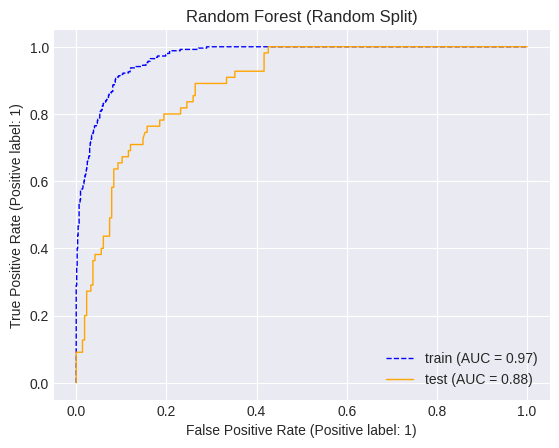

In [5]:
# Random Forest
# GRID SEARCH - hyperparameters
start_time = datetime.now()
print('start time:', str(start_time))

#scale the data X_train and X_test
cols = X_train_df.columns
sc = StandardScaler()
X_train_df = pd.DataFrame(sc.fit_transform(X_train_df), columns=cols)
X_test_df = pd.DataFrame(sc.transform(X_test_df), columns=cols)


# GRID SEARCH
# instantiate at zer0 before the loop
best_score = 0.0 #

# these are the hyperparameters to search through
param_grid = {
    'max_depth': list(np.arange(15, 30, step=6)) + [None], # none for uncapped
    'n_estimators': np.arange(100, 210, step=50),
    'max_features': [int(np.round(np.sqrt(len(features))))],
    'min_samples_leaf': np.arange(3, 10, step=3),
    'min_samples_split': np.arange(4, 10, step=2),
} 

for params in ParameterGrid(param_grid):
    max_depth = params['max_depth']
    n_estimators = params['n_estimators']
    max_features = params['max_features']
    min_samples_leaf = params['min_samples_leaf']
    min_samples_split = params['min_samples_split']


    # instantiate and fit model on training data
    clf = RandomForestClassifier(
        criterion = 'gini',
        max_depth = max_depth,
        n_estimators = n_estimators,
        max_features = max_features,
        min_samples_leaf = min_samples_leaf,
        min_samples_split = min_samples_split,
        random_state=seed,
        n_jobs=-1 # use all compute
    )

    clf.fit(X_train_df, y_train_df)

    # predict training data bool
    y_train_pred_proba = clf.predict_proba(X_train_df)
    # it returns the proba complents so get get proba of 1
    y_train_pred_proba = pd.DataFrame(y_train_pred_proba)[1]
    # predict testing data bool
    y_test_pred_proba = clf.predict_proba(X_test_df)
    # it returns the proba complents so get get proba of 1
    y_test_pred_proba = pd.DataFrame(y_test_pred_proba)[1]

    # predict training data bool
    y_train_pred_bool = clf.predict(X_train_df)
    # predict testing data bool
    y_test_pred_bool = clf.predict(X_test_df)


    # calculate accuracy
    train_accuracy = accuracy_score(y_train_df, y_train_pred_bool)
    test_accuracy = accuracy_score(y_test_df, y_test_pred_bool)

    # calculate precision
    test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

    # calculate recall
    test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

    # calculate f1
    f1_test = f1_score(y_test_df, y_test_pred_bool)

    # extract AUC for printing
    auc_test = roc_auc_score(y_test_df, y_test_pred_proba) 


    # evaluate parameters on given metric and log parameters
    score = auc_test # AUC optimized
    
    if score > best_score:
        best_score = score
        best_params = params

        # and if this is the best, update the dateframe with the given metrics
        best_train_accuracy = train_accuracy
        best_test_accuracy = test_accuracy
        best_precision = test_precision
        best_recall = test_recall_score
        best_f1 = f1_test
        best_auc = auc_test
        
model_name = clf.__class__.__name__
print(f'Architecture:  {model_name}')
print('hyperparameters:')
for key in best_params.keys():
    print(key + ":", best_params[key])
print("\n")

# accuracy
print(f'Training accuracy: {best_train_accuracy}')
print(f'Test accuracy: {best_test_accuracy}')
print('\n')

# precision
print(f'Precision (test): {best_precision}')
print('\n')    

# recall
print(f'Recall (test): {best_recall}')
print('\n')

# f1
print(f'F1 Score (test): {best_f1}')
print('\n')

# AUC
print(f'AUC (test): {best_auc}')
print('\n')

end_time = datetime.now()
print('end time:', str(end_time))
elapsed_time = end_time - start_time
print('elapsed time:', str(elapsed_time))
print("\n")

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train_df, 
                                 y_train_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='blue', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test_df, 
                                 y_test_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='orange', 
                                 name='test');

plt.title('Random Forest (Random Split)');

start time: 2023-06-14 20:29:59.181836
end time: 2023-06-14 20:30:00.319499
elapsed time: 0:00:01.137663


Architecture:  RandomForestClassifier
hyperparameters:
max_depth: 21
max_features: 4
min_samples_leaf: 3
min_samples_split: 4
n_estimators: 200


Training accuracy: 0.9605704697986577
Test accuracy: 0.8597785977859779


Precision (test): 0.6808510638297872


Recall (test): 0.5818181818181818


F1 Score (test): 0.627450980392157


AUC (test): 0.8975589225589226




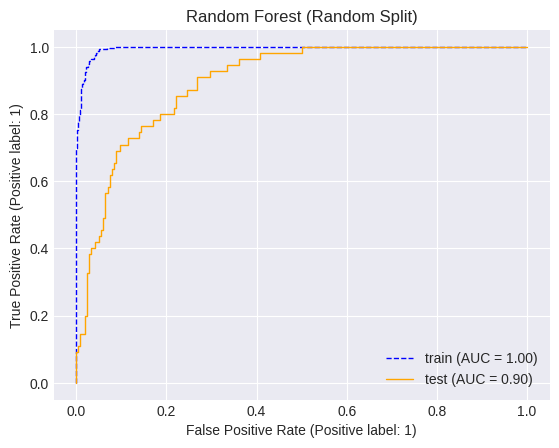

In [6]:
# model with the tuned features
start_time = datetime.now()
# print('start time:', str(start_time))

# hyperparameters selected from above
max_depth = best_params['max_depth']
n_estimators = best_params['n_estimators']
max_features = best_params['max_features']
min_samples_leaf = best_params['min_samples_leaf']
min_samples_split = best_params['min_samples_split']

# instantiate and fit model on training data
clf = RandomForestClassifier(
    criterion = 'gini',
    max_depth = max_depth,
    n_estimators = n_estimators,
    max_features = max_features,
    min_samples_leaf = min_samples_leaf,
    min_samples_split = min_samples_split,
    random_state=seed,
)

clf.fit(X_train_df, y_train_df)

# predict training data bool
y_train_pred_proba = clf.predict_proba(X_train_df)
# it returns the proba complents so get get proba of 1
y_train_pred_proba = pd.DataFrame(y_train_pred_proba)[1]
# predict testing data bool
y_test_pred_proba = clf.predict_proba(X_test_df)
# it returns the proba complents so get get proba of 1
y_test_pred_proba = pd.DataFrame(y_test_pred_proba)[1]

# predict training data bool
y_train_pred_bool = clf.predict(X_train_df)
# predict testing data bool
y_test_pred_bool = clf.predict(X_test_df)


# calculate accuracy
train_accuracy = accuracy_score(y_train_df, y_train_pred_bool)
test_accuracy = accuracy_score(y_test_df, y_test_pred_bool)

# calculate precision
test_precision = precision_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

# calculate recall
test_recall_score = recall_score(y_test_df, y_test_pred_bool, average='binary', zero_division=0)

# calculate f1
f1_test = f1_score(y_test_df, y_test_pred_bool)

# extract AUC for printing
auc_test = roc_auc_score(y_test_df, y_test_pred_proba) 

end_time = datetime.now()
print('start time:', str(start_time))
print('end time:', str(end_time))
elapsed_time = end_time - start_time
print('elapsed time:', str(elapsed_time))
print("\n")

model_name = clf.__class__.__name__
print(f'Architecture:  {model_name}')
print('hyperparameters:')
for key in best_params.keys():
    print(key + ":", best_params[key])
print("\n")

# accuracy
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')
print('\n')

# precision
print(f'Precision (test): {test_precision}')
print('\n')    

# recall
print(f'Recall (test): {test_recall_score}')
print('\n')

# f1
print(f'F1 Score (test): {f1_test}')
print('\n')

# AUC
print(f'AUC (test): {auc_test}')
print('\n')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train_df, 
                                 y_train_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='blue', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test_df, 
                                 y_test_pred_proba,
                                 ax=ax, 
                                 linewidth=1, 
                                 color='orange', 
                                 name='test');

plt.title('Random Forest (Random Split)');

# Confusion Matrix

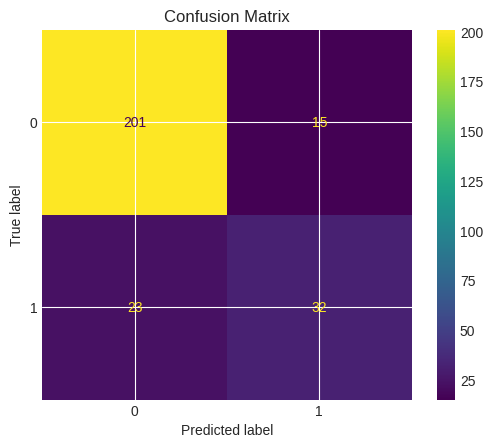

In [7]:
cm = confusion_matrix(y_test_df, y_test_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
plt.title('Confusion Matrix');

In [8]:
# create dataframe with test values
test_assess = pd.DataFrame(y_test_df).astype(int).rename(columns={'response': 'y_test'})
# predicted values
test_assess['y_test_pred'] = y_test_pred_bool.flatten().astype(int)
# whether they are correctly predicted
test_assess['pred_correct'] = test_assess['y_test'] == test_assess['y_test_pred']
# the probability of the prediction
test_assess['y_test_pred_proba'] = y_test_pred_proba.astype(np.float16).values # reduce precision to prevent downstream errors

# create column for confusion matrix
# we'll use this to assess the probabilities
# there's a dataframe for each of these if needed
TP = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == True)]
FP = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == False)]
TN = test_assess[(test_assess['y_test'] == 0) & (test_assess['pred_correct'] == True)]
FN = test_assess[(test_assess['y_test'] == 1) & (test_assess['pred_correct'] == False)]

test_assess.loc[TP.index,'confusion'] = 'TP'
test_assess.loc[FP.index,'confusion'] = 'FP'
test_assess.loc[TN.index,'confusion'] = 'TN'
test_assess.loc[FN.index,'confusion'] = 'FN'

# bring in the state values
test_assess = pd.merge(test_assess, df['state'], how='left', left_index=True, right_index=True)

test_assess

,y_test,y_test_pred,pred_correct,y_test_pred_proba,confusion,state
2,0,0,True,0.007851,TN,CA
6,0,0,True,0.014343,TN,CA
10,0,0,True,0.000556,TN,CA
29,1,1,True,0.651855,TP,ID
35,1,1,True,0.864746,TP,ID
...,...,...,...,...,...,...
1446,0,0,True,0.120728,TN,AZ
1447,0,0,True,0.473633,TN,AZ
1448,0,0,True,0.302734,TN,AZ
1449,0,0,True,0.261230,TN,AZ


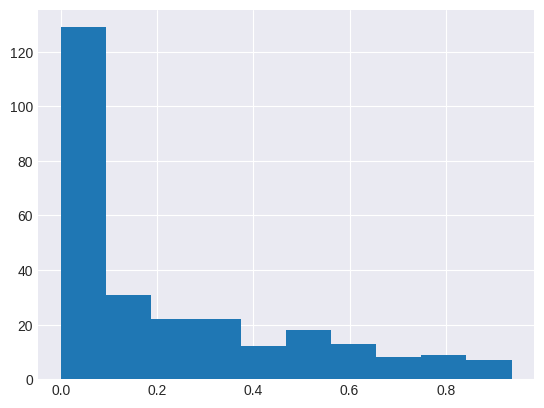

In [9]:
# overall probability distribution
test_assess['y_test_pred_proba'].hist();

In [10]:
# records were there was actually YES debris flow
subset = ['TP', 'FN']
flows = test_assess[test_assess['confusion'].isin(subset)]

# records were there was actually NO debris flow
subset = ['TN', 'FP']
no_flows = test_assess[test_assess['confusion'].isin(subset)]

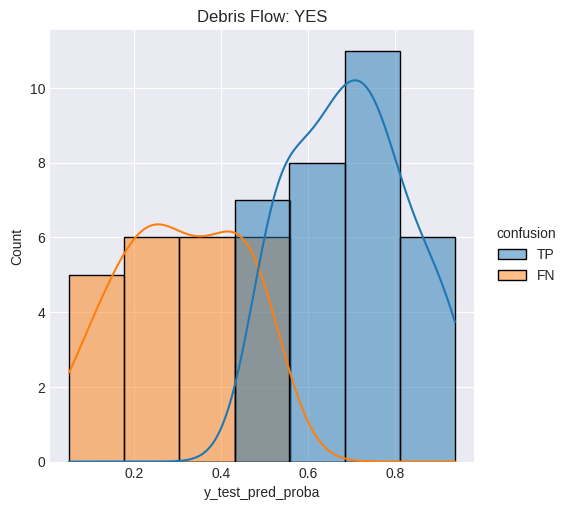

In [11]:
sns.displot(data=flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: YES');

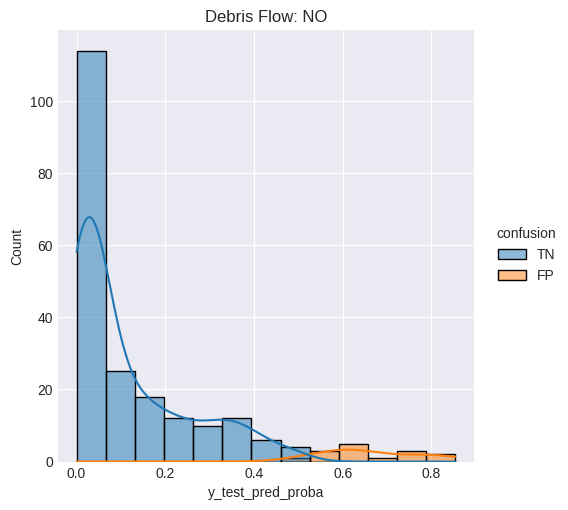

In [12]:
# seaborn has a hard time with the really small probabilities
sns.displot(data=no_flows, x='y_test_pred_proba', hue='confusion', kde=True);
plt.title('Debris Flow: NO');

In [13]:
# this let's us see where are performance is coming from
# it's the percentage of each metric by state
state_matrix = test_assess.groupby(['confusion'])['state'].value_counts(normalize=True).unstack().fillna(0)#.astype(int)
state_matrix = state_matrix.loc[['TP', 'FN', 'TN', 'FP'],:]
state_matrix

state,AZ,CA,CO,ID,MT,NM
confusion,,,,,,
TP,0.000000,0.843750,0.062500,0.062500,0.000000,0.031250
FN,0.130435,0.608696,0.130435,0.000000,0.086957,0.043478
TN,0.119403,0.512438,0.333333,0.000000,0.014925,0.019900
FP,0.200000,0.333333,0.066667,0.066667,0.200000,0.133333


In [14]:
# we can use this to determine
# is our confusion matrix is overindexing on certain state(s)
state_counts = test_assess['state'].value_counts(normalize=True).sort_index()
state_counts

AZ    0.110701
CA    0.549815
CO    0.269373
ID    0.011070
MT    0.029520
NM    0.029520
Name: state, dtype: float64

In [15]:
confusion_index = state_matrix.div(state_counts) - 1
confusion_index

state,AZ,CA,CO,ID,MT,NM
confusion,,,,,,
TP,-1.000000,0.534606,-0.767979,4.645833,-1.000000,0.058594
FN,0.178261,0.107091,-0.515783,-1.000000,1.945652,0.472826
TN,0.078607,-0.067982,0.237443,-1.000000,-0.494403,-0.325871
FP,0.806667,-0.393736,-0.752511,5.022222,5.775000,3.516667


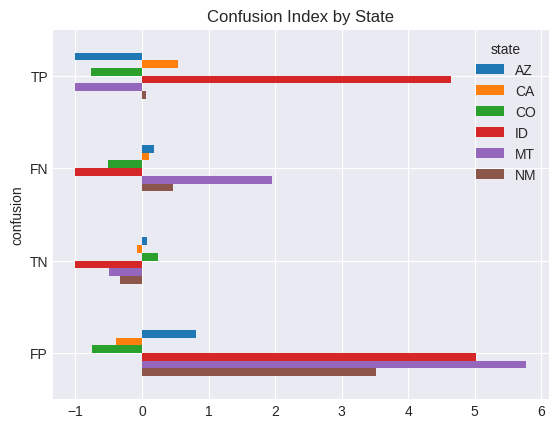

In [16]:
confusion_index.plot(kind='barh').invert_yaxis();
plt.title('Confusion Index by State');